# Image Tokenization Using [NVIDIA Cosmos Tokenizer](https://github.com/NVIDIA/Cosmos/blob/main/cosmos1/models/tokenizer) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nvidia/Cosmos/blob/main/cosmos1/models/tokenizer/notebook/Image_Tokenization.ipynb)

The Jupyter Notebook example utilizes the **Cosmos-Tokenizer** pretrained models, which include Continuous Image (CI) tokenizers that transform images into continuous latents and Discrete Image (DI) tokenizers that transform images into discrete tokens. Both CI and DI tokenizers are available with compression rates of 8x8 and 16x16. For instance, **CI16x16** effectively downsizes both height and width by a factor of 16.

Within the notebook, the `ImageTokenizer` class from the `cosmos_tokenizer.image_lib` module is employed to manage the encoder and decoder components of this model. The encoder compresses the input image into a condensed latent representation or discrete integers, while the decoder reconstructs the image from this latent representation or discrete integers.

This instance of the Cosmos Tokenizer demonstrates its autoencoding capability: compressing an image into a smaller latent space and subsequently reconstructing it to its original form. This showcases the efficiency of image tokenization for tasks involving significant spatial compression during image reconstruction, a highly desirable feature for generative modeling.


This tutorial follows a simple, step-by-step approach, making it easy to understand and adapt.

## Step 1: Clone the Cosmos Tokenizer Repository

In [ ]:
!git clone https://github.com/NVIDIA/Cosmos.git

## Step 2: Install **Cosmos-Tokenizer**
Before proceeding, ensure you have the **Cosmos Tokenizer** installed. If you cloned the repository in Step 1, use the following command to install it in editable mode:

In [ ]:
# Step 2: # Install Cosmos and its Python dependencies.
import os
if os.path.exists("Cosmos"):
    os.chdir("Cosmos")
    %pip install -r requirements.txt
else:
    print('Cosmos-Tokenizer is already installed.')

## Step 3: Set Up Hugging Face API Token and Download Pretrained Models

In this step, you'll configure the Hugging Face API token and download the pretrained model weights required for the **Cosmos Tokenizer**.

1. **Ensure You Have a Hugging Face Account**  
   If you do not already have a Hugging Face account, follow these steps to create one and generate an API token:
   - Go to the [Hugging Face website](https://huggingface.co/) and sign up for a free account.
   - After logging in, navigate to your [Settings → Access Tokens](https://huggingface.co/settings/tokens).
   - Click on "New Token" to generate an API token with the required permissions.

2. **Set the Hugging Face Token**  
   Check if the Hugging Face token is already set in the environment variables. If not, you will be prompted to enter it manually. The token is essential to authenticate and access the Hugging Face models.



In [ ]:
# Check if the token is already set
if "HUGGINGFACE_TOKEN" not in os.environ:
    os.environ["HUGGINGFACE_TOKEN"] = input("Please enter your Hugging Face API token: ")
!git config --global credential.helper store

In [ ]:
from huggingface_hub import login, snapshot_download
import os
HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN")
login(token=HUGGINGFACE_TOKEN, add_to_git_credential=True)
model_names = [
        "Cosmos-0.1-Tokenizer-CI8x8",
        "Cosmos-0.1-Tokenizer-CI16x16",
        "Cosmos-0.1-Tokenizer-DI8x8",
        "Cosmos-0.1-Tokenizer-DI16x16",
]
for model_name in model_names:
    hf_repo = "nvidia/" + model_name
    local_dir = "checkpoints/" + model_name
    os.makedirs(local_dir, exist_ok=True)
    print(f"downloading {model_name}...")
    snapshot_download(repo_id=hf_repo, local_dir=local_dir)

## Step 4: Use Cosmos Tokenizer for Image Reconstruction



Input image read from:	 /content/Cosmos-Tokenizer/test_data/image.png
Reconstruction saved:	 /content/Cosmos-Tokenizer/test_data/image_CI8x8.png


Input Image,Reconstructed Image

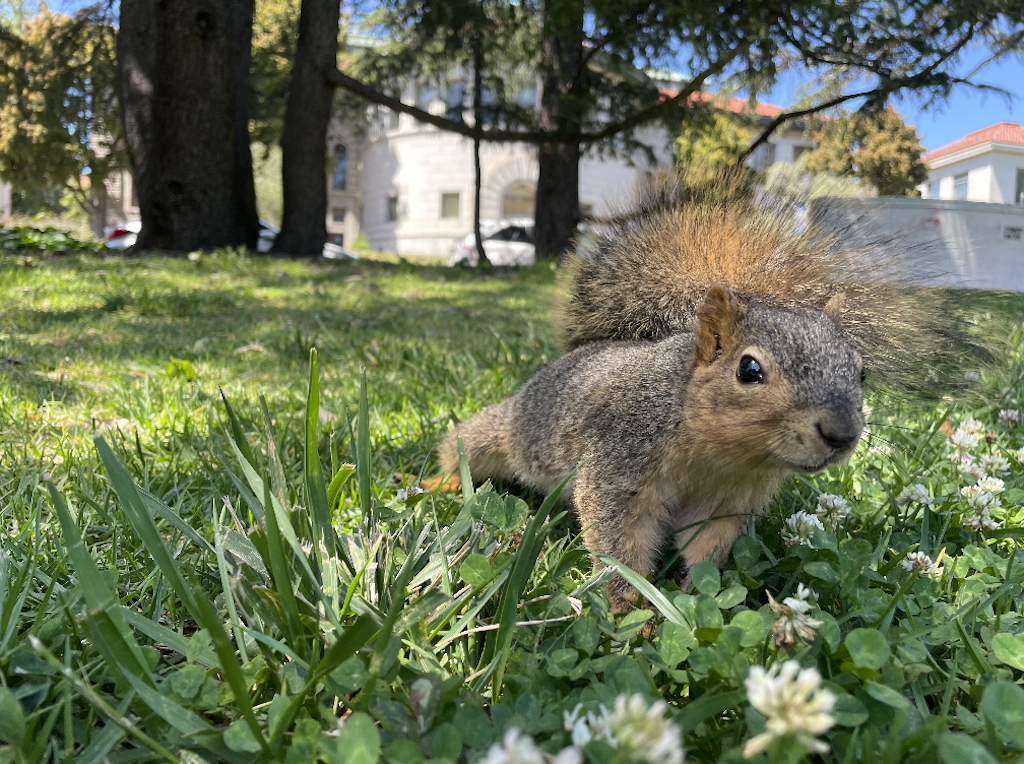
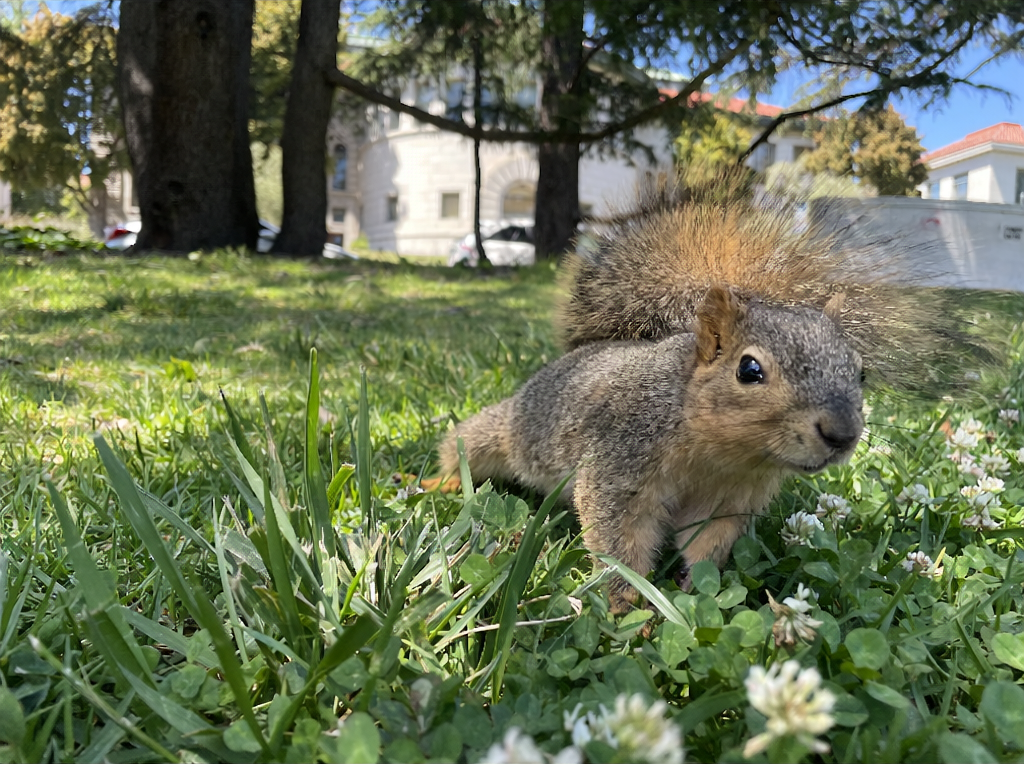

In [ ]:
# @title In this step, load the required checkpoints, and perform image reconstruction. {"run":"auto"}
import cv2
import numpy as np
import torch

import importlib
from cosmos1.models.tokenizer.inference.image_lib import ImageTokenizer
import mediapy as media


# 1) Specify the model name, and the paths to the encoder/decoder checkpoints.
model_name = 'Cosmos-0.1-Tokenizer-CI8x8' # @param ["Cosmos-0.1-Tokenizer-CI16x16", "Cosmos-0.1-Tokenizer-CI8x8", "Cosmos-0.1-Tokenizer-DI8x8", "Cosmos-0.1-Tokenizer-DI16x16"]

encoder_ckpt = f"checkpoints/{model_name}/encoder.jit"
decoder_ckpt = f"checkpoints/{model_name}/decoder.jit"

# 2) Load or provide the image filename you want to tokenize & reconstruct.
input_filepath = "cosmos1/models/tokenizer/test_data/image.png"

# 3) Read the image from disk (shape = H x W x 3 in BGR). Then convert to RGB.
input_image = media.read_image(input_filepath)[..., :3]
assert input_image.ndim == 3 and input_image.shape[2] == 3, "Image must have shape H x W x 3"

# 4) Expand dimensions to B x H x W x C, since the ImageTokenizer expects a batch dimension
#    in the input. (Batch size = 1 in this example.)
batched_input_image = np.expand_dims(input_image, axis=0)

# 5) Create the ImageTokenizer instance with the encoder & decoder.
#    - device="cuda" uses the GPU
#    - dtype="bfloat16" expects Ampere or newer GPU (A100, RTX 30xx, etc.)
tokenizer = ImageTokenizer(
    checkpoint_enc=encoder_ckpt,
    checkpoint_dec=decoder_ckpt,
    device="cuda",
    dtype="bfloat16",
)

# 6) Use the tokenizer to autoencode (encode & decode) the image.
#    The output is a NumPy array with shape = B x H x W x C, range [0..255].
batched_output_image = tokenizer(batched_input_image)

# 7) Extract the single image from the batch (index 0), convert to uint8.
output_image = batched_output_image[0]

# 9) Save the reconstructed image to disk.
input_dir, input_filename = os.path.split(input_filepath)
filename, ext = os.path.splitext(input_filename)
output_filepath = f"{input_dir}/{filename}_{model_name.split('-')[-1]}{ext}"
media.write_image(output_filepath, output_image)
print("Input image read from:\t", f"{os.getcwd()}/{input_filepath}")
print("Reconstruction saved:\t", f"{os.getcwd()}/{output_filepath}")

# 10) Visualization of the input image (left) and the reconstruction (right).
media.show_images([input_image, output_image], ["Input Image", "Reconstructed Image"])